In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import cv2 # OpenCV library(Open Computer Vision)
from sklearn.metrics import confusion_matrix, roc_curve
import datetime
import io
import os
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, MaxPool2D, Flatten, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1
from tensorboard.plugins.hparams import api as hp

# Wandb Install, Login, Initialization and Configuration

In [3]:
# !pip install wandb

In [4]:
import wandb

In [5]:
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [6]:
!wandb login 

wandb: Currently logged in as: adiyan-andranik (adiyan-andranik-neuralearn). Use `wandb login --relogin` to force relogin


In [7]:
wandb.init(project="Malaria-Detection", entity="adiyan-andranik-neuralearn")

###wandb.tensorboard.patch(root_logdir="./logs")
#wandb.init(project="Malaria-Detection", entity="adiyan-andranik-neuralearn", sync_tensorboard=True)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: adiyan-andranik (adiyan-andranik-neuralearn). Use `wandb login --relogin` to force relogin


In [8]:
# wandb.run

In [7]:
wandb.config = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 5,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

# Data Preparation

## Data Loading

In [8]:
dataset, dataset_info = tfds.load('malaria', with_info=True, 
                                  as_supervised=True, 
                                  shuffle_files=True, 
                                  split=['train'])

In [11]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [13]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(TEST_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [14]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Dataset Visualization

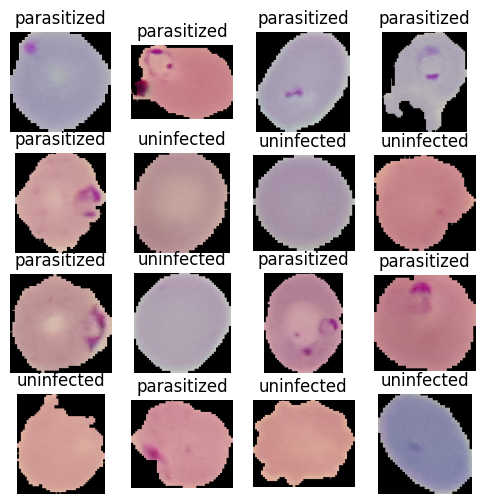

In [15]:
plt.figure(figsize=(6, 6))
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

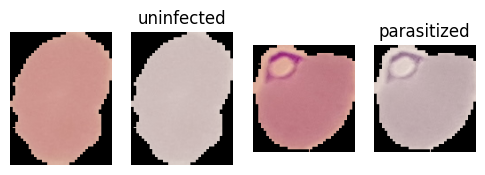

In [16]:
plt.figure(figsize=(6, 6))
for i, (image, label) in enumerate(train_dataset.take(2)):
    plt.subplot(1, 4, 2*i + 1)
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 4, 2*i + 2)
    plt.imshow(tf.image.adjust_saturation(image, saturation_factor=0.3))

    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

# Data Preprocessing

## Data Augmentation

In [17]:
def visualize(original, augmented):
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    
    plt.subplot(1, 2, 2)
    plt.imshow(augmented)

In [18]:
original_image, label = next(iter(train_dataset))

In [19]:
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor = 0.3)

None


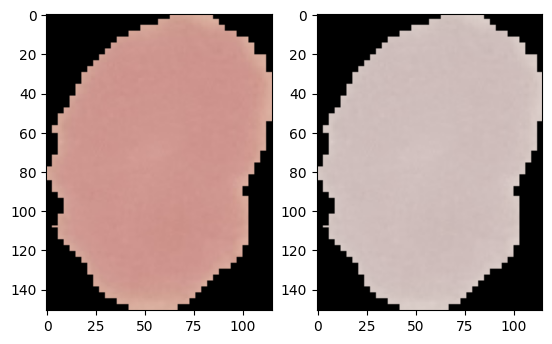

In [20]:
print(visualize(original_image, augmented_image))

In [21]:
IM_SIZE = 224

In [22]:
original_image, label = next(iter(train_dataset))
@tf.function
def resize_rescale(image, label):
  #print("I was here")
  #tf.print("I was here")
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

_, _ = resize_rescale(original_image, label)
_, _ = resize_rescale(original_image, label)

In [23]:
### tf.keras.layers resizing and rescaling
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0 / 255),
])

In [24]:
### tf.image augment
@tf.function
def augment(image, label):

    image, label = resize_rescale(image, label)
    
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32)) # k -> te qani angam modely 90^ rotate ani
    # image = tf.image.adjust_saturation(image, saturation_factor=0.3)
    # image = tf.image.stateless_random_saturation(image, lower=0.3, upper=0.5)
    image = tf.image.flip_left_right(image)
    # image = tf.image.stateless_random_flip_left_right(image)

    return image, label

In [25]:
class RotNinety(Layer):
    def __init__(self):
        super().__init__()

    @tf.function
    def call(self, image):
        return tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))

In [26]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
    # RandomRotation(factor = (0.25, 0.2501), ), #since it taking 2pi(360), so for 90 we need 25% of 360
    RotNinety(),
    RandomFlip(mode = 'horizontal'),
])

@tf.function
def augment_layer(image, labels):
    return augment_layers(resize_rescale_layers(image), training = True), labels

## Data Loading

In [27]:
BATCH_SIZE = 32

In [28]:
test_dataset = test_dataset.map(resize_rescale,num_parallel_calls = tf.data.AUTOTUNE)

In [30]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [31]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 32)
    .map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
)

In [32]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [33]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# WandB Dataset Versioning

## Data Loading

In [35]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True, split=['train'])

print(dataset)

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]


In [36]:
k = 0
for data in dataset[0]:
    with open(f'dataset/malaria_dataset_{k}.npz', mode='wb') as file:
        np.savez(file, data=np.array(data, dtype=object))
    k += 1
    if k % 1000 == 0:
        print(k)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [39]:
def load_original_data():
    with wandb.init(project="Malaria-Detection", entity="adiyan-andranik-neuralearn") as run:
    
        original_data = wandb.Artifact(
            name = "new_dataset", 
            type="raw_data",
            description = "The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.",
            metadata = {"source": "TFDS",
                        "homepage": "https://lhncbc.nlm.nih.gov/publication/pub9932",
                        "source_code": "tfds.image_classification.Malaria",
                        "version": "1.0.0",
                        "download_size": "337.08 MiB",
                        }
        )
    
        original_data.add_dir('dataset/')

        run.log_artifact(original_data)

In [40]:
load_original_data()

wandb: Adding directory to artifact (.\dataset)... Done. 34.1s


## Data Preprocessing

In [41]:
with wandb.init(project="Malaria-Detection", entity="adiyan-andranik-neuralearn") as run:    
    artifact = run.use_artifact('Malaria-Detection/new_dataset:v0', type='raw_data')
    artifact_dir = artifact.download()

wandb: Downloading large artifact new_dataset:v0, 1423.75MB. 27558 files... 
wandb:   27558 of 27558 files downloaded.  
Done. 0:6:41.1


In [43]:
IM_SIZE = 224
def resize_rescale(image):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0

In [47]:
artifact_dir

'D:\\ML\\ComputerVision\\Building Convolutional Neural Networks with TensorFlow [Malaria Diagnosis]\\artifacts\\new_dataset-v0'

In [73]:
def preprocess_data():
    with wandb.init(project="Malaria-Detection", entity="adiyan-andranik-neuralearn") as run:
        
        artifact = run.use_artifact('Malaria-Detection/new_dataset:v0', type='raw_data')
        artifact_dir = artifact.download()
        
        preprocessed_data = wandb.Artifact(
            name = "preprocessed_dataset", 
            type="preprocessed_data",
            description = "A Preprocessed version of the Malaria dataset",
        )

        artifact_directory = "artifacts/new_dataset-v0/"

        dataset_x = []
        dataset_y = []
        
        for f in os.listdir(artifact_directory)[:1000]:
            with open(artifact_directory + f, 'rb') as file:
                npz_array = np.load(file, allow_pickle = True)
                
                x, y = npz_array['data']
                
                dataset_x.append(resize_rescale(x))
                dataset_y.append(y)

        # dataset = tf.data.Dataset.from_tensor_slices((dataset_x, dataset_y))

        with preprocessed_data.new_file("prep_dataset.npz", mode = "wb") as file:
            np.savez(file, dataset_x=np.array(dataset_x, dtype=object), dataset_y=np.array(dataset_y, dtype=object)])
        run.log_artifact(preprocessed_data)

In [74]:
preprocess_data()

wandb: Downloading large artifact new_dataset:v0, 1423.75MB. 27558 files... 
Exception ignored in:  files downloaded...<function ZipFile.__del__ at 0x000002CA43261120>
Traceback (most recent call last):
  File "C:\Users\adiya\AppData\Local\Programs\Python\Python312\Lib\zipfile\__init__.py", line 1929, in __del__
    self.close()
  File "C:\Users\adiya\AppData\Local\Programs\Python\Python312\Lib\zipfile\__init__.py", line 1946, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file
wandb:   27558 of 27558 files downloaded.  
Done. 0:1:7.2


## Data Spliting

In [34]:
run = wandb.init()
artifact = run.use_artifact('adiyan-andranik-neuralearn/Malaria-Detection/preprocessed_dataset:v0', type='preprocessed_data')
artifact_dir = artifact.download()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: adiyan-andranik (adiyan-andranik-neuralearn). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact preprocessed_dataset:v0, 1292.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:8.0


In [44]:
def split_data():
    with wandb.init(project="Malaria-Detection", entity="adiyan-andranik-neuralearn") as run:
        
        artifact = run.use_artifact('adiyan-andranik-neuralearn/Malaria-Detection/preprocessed_dataset:v0', type='preprocessed_data')
        artifact_dir = artifact.download()

        train_data = wandb.Artifact(
            name = "train_dataset", 
            type="preprocessed_data",
            description = "Training dataset",
            
        )
        
        val_data = wandb.Artifact(
            
            name = "val_dataset", 
            type="preprocessed_data",
            description = "Validation dataset",
                
            )
        
        test_data = wandb.Artifact(
            name = "test_dataset", 
            type="preprocessed_data",
            description = "Test dataset",
                
            )
        
        artifact_file = "artifacts/preprocessed_dataset-v0/prep_dataset.npz"
    
        with open(artifact_file, 'rb') as file:
            npz_arr = np.load(file, allow_pickle = True)
            print(npz_arr.files)
            dataset_x = npz_arr['dataset_x']
            dataset_y = npz_arr['dataset_y']
    
        train_split = 0.8
        val_split = 0.1
        test_split = 0.1
        
        data_len = len(dataset_x)

        train_arr = [dataset_x[:int(train_split * data_len)], dataset_y[:int(train_split * data_len)]]
        val_arr = [dataset_x[int(train_split * data_len):int((train_split + val_split) * data_len)],
                   dataset_y[int(train_split * data_len):int((train_split + val_split) * data_len)]]
        test_arr = [dataset_x[int((train_split + val_split) * data_len):],
                    dataset_y[int((train_split + val_split) * data_len):]]
        
          
        with train_data.new_file("train_dataset.npz", mode="wb") as file:
            np.savez(file, dataset_x=train_arr[0], dataset_y=train_arr[1])
            
        with val_data.new_file("val_dataset.npz", mode="wb") as file:
            np.savez(file, dataset_x=val_arr[0], dataset_y=val_arr[1])
            
        with test_data.new_file("test_dataset.npz", mode="wb") as file:
            np.savez(file, dataset_x=test_arr[0], dataset_y=test_arr[1])
            
    
        run.log_artifact(train_data)  
        run.log_artifact(val_data)      
        run.log_artifact(test_data)

In [45]:
split_data()

wandb: Downloading large artifact preprocessed_dataset:v0, 1292.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.4


['dataset_x', 'dataset_y']


## Data Augmentation

In [56]:
# run = wandb.init()
# artifact = run.use_artifact('adiyan-andranik-neuralearn/Malaria-Detection/train_dataset:v0', type='preprocessed_data')
# artifact_dir = artifact.download()

In [57]:
# wandb.finish()

In [34]:
### tf.image augment
def augment(image):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    image = tf.image.rot90(image)
    image = tf.image.flip_left_right(image)
    return image

In [35]:
def augment_data():
    with wandb.init(project="Malaria-Detection", entity="adiyan-andranik-neuralearn") as run:

        artifact = run.use_artifact('adiyan-andranik-neuralearn/Malaria-Detection/train_dataset:v0', type='preprocessed_data')
        artifact_dir = artifact.download()
    
        augmented_data = wandb.Artifact(
            name = "Augmented_dataset", 
            type="preprocessed_data",
            description = "An Augmented version of the Malaria train dataset",
        )
    
        artifact_file = "artifacts/train_dataset-v0/train_dataset.npz"
        
        dataset_x = []
    
        with open(artifact_file, 'rb') as file:
            npz_array = np.load(file, allow_pickle = True)

            print(npz_array.files)
            arr_x = npz_array['dataset_x']
            arr_y = npz_array['dataset_y']
            
    
            for im in arr_x:
              dataset_x.append(augment(im))
            dataset_y = arr_y
    
        with augmented_data.new_file("aug_dataset.npz", mode = "wb") as file:
            np.savez(file, dataset_x=np.array(dataset_x, dtype=object), dataset_y=np.array(dataset_y, dtype=object))
        run.log_artifact(augmented_data)

In [36]:
augment_data()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: adiyan-andranik (adiyan-andranik-neuralearn). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact train_dataset:v0, 1033.86MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.1


['dataset_x', 'dataset_y']


# Model Creation

## Sequential API

In [40]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    # resize_rescale_layers,
    # augment_layers,
    
    Conv2D (filters = N_FILTERS, kernel_size = KERNEL_SIZE, strides = N_STRIDES, padding = 'valid', activation = 'relu',
           kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides = N_STRIDES * 2),
    Dropout(rate = DROPOUT_RATE),

    Conv2D (filters = N_FILTERS * 2 + 4, kernel_size = KERNEL_SIZE, strides = N_STRIDES, padding = 'valid', activation = 'relu',
           kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides = N_STRIDES * 2),

    Flatten(),

    Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),
    

    Dense(CONFIGURATION['N_DENSE_2'], activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(1, activation = 'sigmoid'),
])
lenet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

## WandB Model Versioning

### Untrained Model Versioning

In [41]:
def log_model():
    with wandb.init(project="Malaria-Detection", entity="adiyan-andranik-neuralearn") as run:

        untrained_model = wandb.Artifact(
            name = "Untrained_model", 
            type="model",
            description = "The initial version of our lenet model",
            metadata = CONFIGURATION
        )
        filename = 'lenet.h5'
        lenet_model.save(filename)

        untrained_model.add_file(filename)
        wandb.save(filename)

        run.log_artifact(untrained_model)

In [42]:
log_model()

### Trained Model Versioning

In [51]:
def train_and_log():
    with wandb.init(project="Malaria-Detection", entity="adiyan-andranik-neuralearn") as run:
        
        artifact = run.use_artifact('adiyan-andranik-neuralearn/Malaria-Detection/Augmented_dataset:v0', type='preprocessed_data')
        artifact_dir = artifact.download()

        trained_sequential_model = wandb.Artifact(
            name = "Trained_Sequential_model",
            type = "model",
            description = "A trained version of our model",
            metadata = CONFIGURATION
        )

        artifact_file = "artifacts/Augmented_dataset-v0/aug_dataset.npz"
        
        dataset_x = []
    
        with open(artifact_file, 'rb') as file:
            npz_array = np.load(file, allow_pickle = True)
            # print(npz_array.files)
            arr_x = npz_array['dataset_x']
            arr_y = npz_array['dataset_y']
            
    
            for im in arr_x:
                dataset_x.append(augment(im))
            dataset_y = arr_y

        d_x = tf.convert_to_tensor(dataset_x, dtype = tf.float32)
        d_y = tf.convert_to_tensor(dataset_y, dtype = tf.float32)

        d = tf.data.Dataset.from_tensor_slices((d_x, d_y))

        train_d = (
            d
            .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE)
        )

        artifact = run.use_artifact('adiyan-andranik-neuralearn/Malaria-Detection/Untrained_model:v0', type='model')
        artifact_dir = artifact.download()

        artifact_file = "artifacts/Untrained_model-v0/lenet.h5"

        lenet_model = tf.keras.models.load_model(artifact_file)

        metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

        lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
            loss = BinaryCrossentropy(),
            metrics = metrics)

        lenet_model.fit(
            train_d,
            epochs = 3,
            verbose = 1,
            callbacks=[WandbMetricsLogger()],
        )
        
        filename = 'lenet_trained.h5'
        lenet_model.save(filename)
    
        trained_sequential_model.add_file(filename)
        wandb.save(filename)
        run.log_artifact(trained_sequential_model)

In [52]:
train_and_log()

wandb: Downloading large artifact Augmented_dataset:v0, 1033.86MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.0
wandb:   1 of 1 files downloaded.  


Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 1:52 5s/step - accuracy: 0.3125 - auc: 0.3393 - fn: 10.0000 - fp: 12.0000 - loss: 1.2308 - precision: 0.2500 - recall: 0.2857 - tn: 6.0000 - tp: 4.00 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.3516 - auc: 0.3139 - fn: 12.5000 - fp: 18.0000 - loss: 1.2152 - precision: 0.2250 - recall: 0.2857 - tn: 12.5000 - tp: 5.00 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.3628 - auc: 0.3208 - fn: 17.0000 - fp: 23.0000 - loss: 1.1876 - precision: 0.2542 - recall: 0.3124 - tn: 15.6667 - tp: 8.33 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.3854 - auc: 0.3408 - fn: 20.2500 - fp: 27.2500 - loss: 1.1446 - precision: 0.2819 - recall: 0.3428 - tn: 20.5000 - tp: 12.000 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.3996 - auc: 0.3541 - fn: 23.6000 - fp: 31.8000 - loss: 1.1117 - precision: 0.3021 - recall: 0.3654 - tn: 24.8000 - tp: 15.800 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.4120 - auc: 0.3690 - fn: 27.0000 - fp: 36.0000 - loss: 1.0824 - prec

epoch/accuracy,▁▆█
epoch/auc,▁▆█
epoch/epoch,▁▅█
epoch/fn,█▃▁
epoch/fp,█▃▁
epoch/learning_rate,▁▁▁
epoch/loss,█▃▁
epoch/precision,▁▆█
epoch/recall,▁▆█
epoch/tn,▁▆█
epoch/tp,▁▆█


# Callbacks

In [38]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print(f'\n For Epoch Number {epoch+1} the model has a loss of {logs["loss"]}')
    def on_batch_end(self, batch, logs):
        print(f'\n For Batch Number {batch+1} the model has a loss of {logs}')
    

In [39]:
test_dataset = test_dataset.batch(1)

In [40]:
class LogImagesCallbackTensorBoard(Callback):
    def on_epoch_end(self, epoch, logs):
        labels = []
        inp = []
        
        for x,y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)
        labels = np.array([i[0] for i in labels])
        predicted = lenet_model.predict(np.array(inp)[:,0,...])
        
        threshold = 0.5
        
        cm = confusion_matrix(labels, predicted > threshold)
        
        plt.figure(figsize=(8,8))
        
        sns.heatmap(cm, annot=True,)
        plt.title('Confusion matrix - {}'.format(threshold))
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.axis('off')
        
        buffer = io.BytesIO()
        plt.savefig(buffer, format = 'png')
        
        image = tf.image.decode_png(buffer.getvalue(), channels=3)
        image = tf.expand_dims(image, axis = 0)
        
        CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %H%M%S')
        IMAGE_DIR = './logs/' + CURRENT_TIME + '/images'
        image_writer = tf.summary.create_file_writer(IMAGE_DIR)
        
        with image_writer.as_default():
            tf.summary.image("Training data", image, step = epoch)

In [41]:
class LogImagesCallbackWandBPlot(Callback):
    def on_epoch_end(self, epoch, logs):
        labels = []
        inp = []
    
        for x,y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)
        labels = np.array([i[0] for i in labels])
        predicted = lenet_model.predict(np.array(inp)[:,0,...])
    
        print("labels", labels, labels.dtype)
        print("predicted", predicted, predicted.dtype)
    
        pred = []
        threshold = 0.5
        
        for i in range(len(predicted)):
            if(predicted[i][0] < threshold):
                pred.append([1,0])
            else:
                pred.append([0,1])
    
        pred = np.array(pred)
    
        # wandb.log({"Confusion Matrix" : wandb.plot.confusion_matrix(
        #     probs = pred,
        #     y_true=labels,
        #     class_names=["Parasitized", "Uninfected"])})
    
        wandb.log({"ROC Curve" : wandb.plot.roc_curve(
            y_true = labels,
            y_probas = pred,
            labels = ['Parasitized', 'Uninfected'], 
        )})
    
        wandb.log({'loss':logs['loss']})

In [42]:
class LogImagesCallbackWandB(Callback):
    def on_epoch_end(self, epoch, logs):
        labels = []
        inp = []

        for x,y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)
        labels = np.array([i[0] for i in labels])
        predicted = lenet_model.predict(np.array(inp)[:,0,...])
    
        threshold = 0.5
    
        cm = confusion_matrix(labels, predicted > threshold)
        
        plt.figure(figsize=(8,8))
    
        sns.heatmap(cm, annot=True,)
        plt.title('Confusion matrix - {}'.format(threshold))
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.axis('off')
    
        buffer = io.BytesIO()
        plt.savefig(buffer, format = 'png')
    
        image_array = tf.image.decode_png(buffer.getvalue(), channels=3)
    
        images = wandb.Image(image_array, caption=f"Confusion Matrix for epoch: {epoch}")
              
        wandb.log(
            {"Confusion Matrix": images})

### CSVLogger

In [43]:
csv_callback = CSVLogger(
    'logs.csv', separator = ',', append = False 
                                                
)

### EarlyStopping

In [44]:
es_callback = EarlyStopping(
    monitor = 'val_loss', min_delta = 0, patience = 2, verbose = 1,
    mode = 'auto', baseline = None, restore_best_weights = False
)

### Tensorboard

In [45]:
# !pip install -U tensorboard_plugin_profile

In [46]:
# import shutil

# shutil.rmtree('./logs/')

In [47]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %H%M%S')
METRIC_DIR = './logs/' + CURRENT_TIME + '/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [48]:
LOG_DIR = './logs/' + CURRENT_TIME
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq = 1, profile_batch = '100,132')

### LearningRateScheduler

In [49]:
def scheduler(epoch, lr):
    if epoch <= 1:
        learning_rate = lr
    else:
        learning_rate = lr * tf.math.exp(-0.1)
        learning_rate = learning_rate.numpy()
    with train_writer.as_default():
        tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
    return learning_rate
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

### ModelCheckpointing

In [50]:
checkpoint_callback = ModelCheckpoint(
    'checkpoints/best_model.keras', monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)
#for val_loss` mode = min, for val_accuracy` mode = max (but auto is setting it automatically)

### ReduceLearningRateOnPlateau

In [51]:
plateau_callback = ReduceLROnPlateau(
    monitor = 'val_accuracy', factor = 0.1, patience = 2, verbose = 1
)

# Custom Metric Class

In [52]:
class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='Custom_Accuracy', FACTOR=1):
        super(CustomAccuracy, self).__init__()
        self.FACTOR = FACTOR
        self.accuracy = self.add_weight(name=name, initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        output = binary_accuracy(tf.cast(y_true, dtype=tf.float32), y_pred) * self.FACTOR
        num_elements = tf.shape(output)[0]
        self.accuracy.assign(tf.math.count_nonzero(output, dtype=tf.float32) / tf.cast(num_elements, dtype=tf.float32))

    def result(self):
        return self.accuracy

    def reset_states(self):
        self.accuracy.assign(0.)

# Custom Metric Method (without parametres)

In [53]:
def custom_accuracy(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)

# Custom Metric Method (with parametres)

In [54]:
FACTOR = 1
def custom_accuracy(FACTOR):
    def metric(y_true, y_pred):
        return binary_accuracy(y_true, y_pred) * FACTOR
    return metric

# Custom Loss Class

In [55]:
FACTOR = 1
class CustomBCE(tf.keras.losses.Loss):
    def __init__(self, FACTOR):
        super(CustomBCE, self).__init__()
        self.FACTOR = FACTOR
    def call(self, y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred) * self.FACTOR

# Custom Loss Method (with parametres)

In [56]:
FACTOR = 1
def custom_bce(FACTOR):
    def loss(y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred) * FACTOR
    return loss

# Custom Loss Method (without parametres)

In [57]:
def custom_bce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)

# Metrics

In [58]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
          BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
FACTOR = 1
LABELS = ['Parasitized', 'Uninfected']

# Model Training

In [62]:
lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
             loss = CustomBCE(FACTOR),
             metrics = [CustomAccuracy()],
             ) 

In [ ]:
history = lenet_model.fit(train_dataset, 
                          validation_data = val_dataset, 
                          epochs = 3, #CONFIGURATION['N_EPOCHS'], 
                          verbose = 1, 
                          callbacks = [
                              LogImagesCallbackWandBPlot(), LogImagesCallbackWandB()
                          ]
                         )

Epoch 1/3
87/8789 ━━━━━━━━━━━━━━━━━━━━ 3:45 328ms/step - custom_accuracy_3: 0.9062 - loss: 0.210 ━━━━━━━━━━━━━━━━━━━━ 2:22 207ms/step - custom_accuracy_3: 0.9531 - loss: 0.174 ━━━━━━━━━━━━━━━━━━━━ 2:20 205ms/step - custom_accuracy_3: 0.9583 - loss: 0.160 ━━━━━━━━━━━━━━━━━━━━ 2:20 205ms/step - custom_accuracy_3: 0.9609 - loss: 0.148 ━━━━━━━━━━━━━━━━━━━━ 2:20 205ms/step - custom_accuracy_3: 0.9563 - loss: 0.141 ━━━━━━━━━━━━━━━━━━━━ 2:20 206ms/step - custom_accuracy_3: 0.9531 - loss: 0.136 ━━━━━━━━━━━━━━━━━━━━ 2:20 205ms/step - custom_accuracy_3: 0.9509 - loss: 0.133 ━━━━━━━━━━━━━━━━━━━━ 2:19 205ms/step - custom_accuracy_3: 0.9492 - loss: 0.132 ━━━━━━━━━━━━━━━━━━━━ 2:19 205ms/step - custom_accuracy_3: 0.9410 - loss: 0.132 ━━━━━━━━━━━━━━━━━━━━ 2:19 205ms/step - custom_accuracy_3: 0.9438 - loss: 0.132 ━━━━━━━━━━━━━━━━━━━━ 2:20 207ms/step - custom_accuracy_3: 0.9460 - loss: 0.132 ━━━━━━━━━━━━━━━━━━━━ 2:21 209ms/step - custom_accuracy_3: 0.9479 - loss: 0.132 ━━━━━━━━━━━━━━━━━━━━ 2:22 211ms/st

In [81]:
# wandb.finish()

# Hyperparameter Tuning with WandB

In [59]:
sweep_config = {
    "name": "Malaria-Prediction-Sweep",
    "method": "random",  
    
    "metric": {
        "name": "accuracy",
        "goal": "maximize"
    },
    
    "parameters": {
    
        "IM_SIZE": {
            "value" : 224,
        },
        
        "N_EPOCHS": {
            "value" : 1,
        },
        
        "KERNEL_SIZE": {
            "value" : 3,
        },
        
        "N_STRIDES": {
            "value" : 1,
        },
        
        "POOL_SIZE": {
            "value" : 224,
        },
        
        "N_FILTERS" : {
            "value" : 6,
        },
        "N_DENSE_1": {
            "values": [16, 32, 34, 128]
        },
        
        "N_DENSE_2": {
            "values": [16, 32, 34, 128]
        },

        "DROPOUT_RATE": {
            "min": 0.1,
            "max": 0.4
        },

        "REGULARIZATION_RATE": {
            "distribution": "uniform",
            "min": 0.001,
            "max": 0.1
        },
        
        "LEARNING_RATE": {
            "distribution": "uniform",
            "min": 1e-4,
            "max": 1e-3
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: xx98gzhq
Sweep URL: https://wandb.ai/adiyan-andranik-neuralearn/uncategorized/sweeps/xx98gzhq


In [60]:
IM_SIZE = 224

def model_tune(config):
    lenet_model = tf.keras.Sequential([
        InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

        Conv2D(filters=6, kernel_size=3, strides=1, padding='valid',
               activation='relu', kernel_regularizer=L2(config['REGULARIZATION_RATE'])),
        BatchNormalization(),
        MaxPool2D(pool_size=1, strides=config['N_STRIDES'] * 2),
        Dropout(rate=config['DROPOUT_RATE']),

        Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',
               activation='relu', kernel_regularizer=L2(config['REGULARIZATION_RATE'])),
        BatchNormalization(),
        MaxPool2D(pool_size=1, strides=2),

        Flatten(),

        Dense(config['N_DENSE_1'], activation="relu", kernel_regularizer=L2(config['REGULARIZATION_RATE'])),
        BatchNormalization(),
        Dropout(rate=config['DROPOUT_RATE']),

        Dense(config['N_DENSE_2'], activation="relu", kernel_regularizer=L2(config['REGULARIZATION_RATE'])),
        BatchNormalization(),

        Dense(1, activation="sigmoid"),
    ])

    return lenet_model


In [61]:
CONFIGURATION = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 1,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}

In [62]:
def train():
    with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:
        config = wandb.config
        model = model_tune(config)
        model.compile(
              optimizer= Adam(
                  learning_rate = config['LEARNING_RATE']),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )
        model.fit(val_dataset, epochs=3, callbacks = [WandbMetricsLogger()])
        #wandb.log({"loss": loss, "epoch": epoch})

count = 5
wandb.agent(sweep_id, function=train, count=count)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: izq220jl with config:
wandb: 	DROPOUT_RATE: 0.1892512879169846
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.0007189044072893477
wandb: 	N_DENSE_1: 128
wandb: 	N_DENSE_2: 16
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 224
wandb: 	REGULARIZATION_RATE: 0.04141893907389791
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


D:\ML\venv\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/3
87/87 ━━━━━━━━━━━━━━━━━━━━ 5:36 4s/step - accuracy: 0.4375 - loss: 13.16 ━━━━━━━━━━━━━━━━━━━━ 18s 219ms/step - accuracy: 0.4766 - loss: 13.13 ━━━━━━━━━━━━━━━━━━━━ 18s 219ms/step - accuracy: 0.4913 - loss: 13.10 ━━━━━━━━━━━━━━━━━━━━ 18s 218ms/step - accuracy: 0.5013 - loss: 13.06 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - accuracy: 0.5123 - loss: 13.02 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - accuracy: 0.5233 - loss: 12.98 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - accuracy: 0.5308 - loss: 12.93 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - accuracy: 0.5377 - loss: 12.87 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.5435 - loss: 12.82 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.5473 - loss: 12.76 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.5497 - loss: 12.70 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/step - accuracy: 0.5525 - loss: 12.63 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/step - accuracy: 0.5548 - loss: 12.57 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/step - accuracy: 0.5563 - loss: 12.50 ━━━━━━━━━━━━━━━━━━━━

epoch/accuracy,▁█▇
epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▂▁
epoch/accuracy,0.63013
epoch/epoch,2
epoch/learning_rate,0.00072
epoch/loss,2.44827


wandb: Agent Starting Run: nbx26z47 with config:
wandb: 	DROPOUT_RATE: 0.39882350350662
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.0008139438826696472
wandb: 	N_DENSE_1: 34
wandb: 	N_DENSE_2: 16
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 224
wandb: 	REGULARIZATION_RATE: 0.032174650654941656
wandb: Currently logged in as: adiyan-andranik. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/3
87/87 ━━━━━━━━━━━━━━━━━━━━ 4:06 3s/step - accuracy: 0.4062 - loss: 4.468 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - accuracy: 0.4375 - loss: 4.398 ━━━━━━━━━━━━━━━━━━━━ 17s 208ms/step - accuracy: 0.4549 - loss: 4.437 ━━━━━━━━━━━━━━━━━━━━ 18s 219ms/step - accuracy: 0.4622 - loss: 4.456 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - accuracy: 0.4685 - loss: 4.471 ━━━━━━━━━━━━━━━━━━━━ 18s 222ms/step - accuracy: 0.4720 - loss: 4.483 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.4767 - loss: 4.487 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.4811 - loss: 4.486 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - accuracy: 0.4863 - loss: 4.481 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - accuracy: 0.4920 - loss: 4.477 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step - accuracy: 0.4969 - loss: 4.471 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 0.4999 - loss: 4.468 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 0.5035 - loss: 4.465 ━━━━━━━━━━━━━━━━━━━━ 15s 211ms/step - accuracy: 0.5072 - loss: 4.461 ━━━━━━━━━━━━━━━━━━━━

epoch/accuracy,▁▆█
epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▃▁
epoch/accuracy,0.6
epoch/epoch,2
epoch/learning_rate,0.00081
epoch/loss,2.14082


wandb: Agent Starting Run: uv8w8b6s with config:
wandb: 	DROPOUT_RATE: 0.35607534947328334
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.0006614773098325574
wandb: 	N_DENSE_1: 16
wandb: 	N_DENSE_2: 32
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 224
wandb: 	REGULARIZATION_RATE: 0.025180690660629588
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/3
87/87 ━━━━━━━━━━━━━━━━━━━━ 4:06 3s/step - accuracy: 0.3750 - loss: 2.890 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - accuracy: 0.4141 - loss: 2.757 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - accuracy: 0.4288 - loss: 2.728 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.4329 - loss: 2.728 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.4401 - loss: 2.721 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.4484 - loss: 2.708 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.4551 - loss: 2.695 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.4622 - loss: 2.683 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.4691 - loss: 2.671 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.4740 - loss: 2.661 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.4790 - loss: 2.654 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.4816 - loss: 2.650 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.4845 - loss: 2.646 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.4870 - loss: 2.642 ━━━━━━━━━━━━━━━━━━━━

epoch/accuracy,▁▄█
epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▃▁
epoch/accuracy,0.6363
epoch/epoch,2
epoch/learning_rate,0.00066
epoch/loss,1.60866


wandb: Agent Starting Run: 65h916qy with config:
wandb: 	DROPOUT_RATE: 0.3608656712826081
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.0006657469302059996
wandb: 	N_DENSE_1: 16
wandb: 	N_DENSE_2: 16
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 224
wandb: 	REGULARIZATION_RATE: 0.08496091334590203
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/3
87/87 ━━━━━━━━━━━━━━━━━━━━ 4:05 3s/step - accuracy: 0.5312 - loss: 5.854 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.5625 - loss: 5.834 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - accuracy: 0.5833 - loss: 5.823 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.5938 - loss: 5.809 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.6012 - loss: 5.792 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.6035 - loss: 5.781 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.6040 - loss: 5.775 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.6056 - loss: 5.768 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.6074 - loss: 5.760 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.6110 - loss: 5.749 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.6133 - loss: 5.738 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.6148 - loss: 5.728 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.6148 - loss: 5.719 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.6147 - loss: 5.709 ━━━━━━━━━━━━━━━━━━━━

epoch/accuracy,▁█▇
epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▃▁
epoch/accuracy,0.6069
epoch/epoch,2
epoch/learning_rate,0.00067
epoch/loss,2.05808


wandb: Agent Starting Run: mt721vub with config:
wandb: 	DROPOUT_RATE: 0.14037833395467067
wandb: 	IM_SIZE: 224
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.0007338796422818285
wandb: 	N_DENSE_1: 128
wandb: 	N_DENSE_2: 16
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 224
wandb: 	REGULARIZATION_RATE: 0.08256786001878186
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/3
87/87 ━━━━━━━━━━━━━━━━━━━━ 4:41 3s/step - accuracy: 0.5625 - loss: 25.40 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - accuracy: 0.5703 - loss: 25.24 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.5677 - loss: 25.15 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step - accuracy: 0.5762 - loss: 25.02 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.5797 - loss: 24.88 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step - accuracy: 0.5812 - loss: 24.73 ━━━━━━━━━━━━━━━━━━━━ 18s 233ms/step - accuracy: 0.5817 - loss: 24.56 ━━━━━━━━━━━━━━━━━━━━ 18s 233ms/step - accuracy: 0.5822 - loss: 24.39 ━━━━━━━━━━━━━━━━━━━━ 18s 232ms/step - accuracy: 0.5823 - loss: 24.21 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - accuracy: 0.5829 - loss: 24.02 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - accuracy: 0.5833 - loss: 23.84 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - accuracy: 0.5833 - loss: 23.65 ━━━━━━━━━━━━━━━━━━━━ 17s 233ms/step - accuracy: 0.5839 - loss: 23.46 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - accuracy: 0.5846 - loss: 23.27 ━━━━━━━━━━━━━━━━━━━━

epoch/accuracy,▁▇█
epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▂▁
epoch/accuracy,0.65699
epoch/epoch,2
epoch/learning_rate,0.00073
epoch/loss,3.01831


# Visualization of Model Performance

In [59]:
%load_ext tensorboard

In [60]:
tensorboard --logdir="./logs"

Reusing TensorBoard on port 6006 (pid 8440), started 23:07:44 ago. (Use '!kill 8440' to kill it.)

# Model Evaluation and Testing

In [32]:
test_dataset = test_dataset.batch(1)

In [33]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 20s 7ms/step - loss: 0.3023 - tp: 1338.0000 - fp: 217.0000 - tn: 1179.0000 - fn: 23.0000 - accuracy: 0.9129 - precision: 0.8605 - recall: 0.9831 - auc: 0.9686


[0.30229803919792175,
 1338.0,
 217.0,
 1179.0,
 23.0,
 0.9129488468170166,
 0.8604501485824585,
 0.9831006526947021,
 0.9686193466186523]

# Visualizing Confusion Matrix

In [64]:
labels = []
inp = []

for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [66]:
predicted = lenet_model.predict(np.array(inp)[:, 0, ...])
print(predicted[:,0])
print(predicted[:,0].shape)

87/87 ━━━━━━━━━━━━━━━━━━━━ 28s 335ms/ste ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step  ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/ste ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/ste ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/ste ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/ste ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste 

tp: 1338.0000 - fp: 217.0000 - tn: 1179.0000 - fn: 23.0000 with scikit-learn

[[1194  198]
 [  31 1334]]


Text(0.5, 14.722222222222216, 'Predicted')

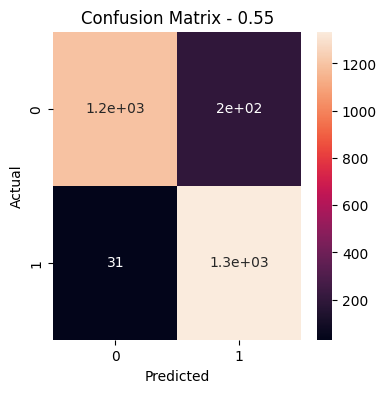

In [67]:
threshold = 0.55

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(4, 4))

sns.heatmap(cm, annot=True)
plt.title(f'Confusion Matrix - {threshold}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Plots

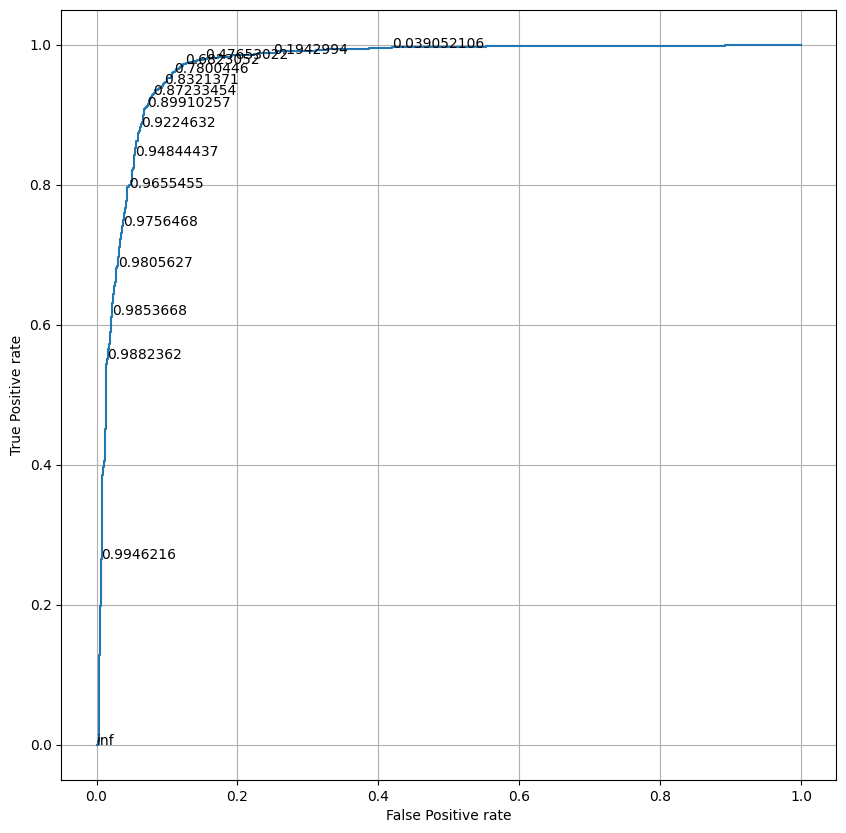

In [68]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.figure(figsize=(10, 10))
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])
  
plt.show()

In [69]:
print(len(fp), len(tp), len(thresholds))

333 333 333


In [70]:
lenet_model.predict(test_dataset.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step


0.9830064

In [71]:
def parasite_or_not(x):
  if x < 0.5:
    return str('P')
  else:
    return str('U')

In [72]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


'U'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


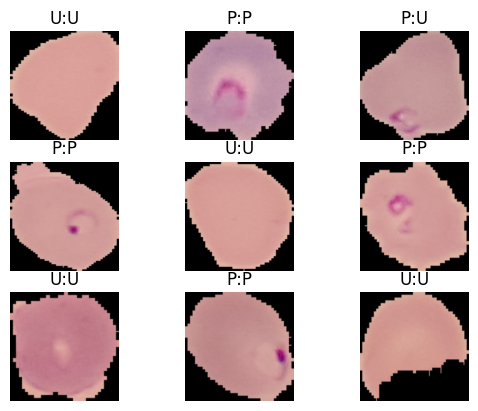

In [73]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))

  plt.axis('off')

# Saving and Loading the Model

### Full Model Save

In [74]:
lenet_model.save('full_model.h5')

### Only Weights Save

In [87]:
lenet_model.save_weights('weights_model.weights.h5')

In [88]:
lenet_weights_model = lenet_model.load_weights("weights_model.weights.h5")